# 量化策略回测框架

本 Notebook 采用模块化设计，按照配置中心、环境加载、数据处理、策略定义、组合与执行、回测引擎、策略执行与性能分析等部分划分。每个部分通过 Markdown 分隔，以实现结构化和可扩展的量化研究框架。

## 1. 配置中心 (Configuration Center)

在此单元格中设置所有可调参数，包括数据路径、初始资金、策略参数、交易成本等。
可通过修改该字典来快速调整实验配置。

In [19]:
# 配置字典，集中管理所有参数
config = {
    'csv_path': 'comprehensive_akshare_soybean_data.csv',      # 数据文件路径
    'symbol': 'SOYBEAN_SPREAD',              # 交易品种（价差）名称
    'initial_capital': 1000000.0,            # 初始资金
    'lookback_window': 60,                   # Z-score 计算窗口
    'z_threshold': 2.0,                      # Z-score 阈值
    'commission': 5.0,                       # 单笔交易佣金（固定值）
    'slippage': 0.01,                        # 单笔交易滑点（固定值）
    'roll_calendar_path': None,              # 展期日历路径（如有）
    # Phase-2 additions
    'signal_persistence': 1,                 # 信号需持续的最小周期
    'vol_window': 20,                        # 波动率计算窗口
    'vol_low': 0.0,                          # 允许的最低波动率
    'vol_high': 10.0,                        # 允许的最高波动率
    'position_sizing_method': 'fixed',       # 持仓管理方法: fixed/inverse_volatility/fixed_fractional
    'risk_fraction': 0.01                    # 每笔交易的风险百分比
}


## 2. 环境与库加载 (Environment & Libraries)

加载本框架所需的所有第三方库和内置模块。

In [20]:
import pandas as pd
import numpy as np
import queue
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

pd.set_option('display.float_format', '{:.6f}'.format)


In [21]:
# 定义事件模型
class Event:
    """基类，用于标识事件类型。"""
    pass

class MarketEvent(Event):
    """行情更新事件。"""
    def __init__(self):
        self.type = 'MARKET'

class SignalEvent(Event):
    """策略发出的交易信号事件。"""
    def __init__(self, symbol, datetime, signal_type, strength=1.0):
        self.type = 'SIGNAL'
        self.symbol = symbol
        self.datetime = datetime
        self.signal_type = signal_type
        self.strength = strength

class OrderEvent(Event):
    """订单事件，用于委托执行系统。"""
    def __init__(self, symbol, order_type, quantity, direction):
        self.type = 'ORDER'
        self.symbol = symbol
        self.order_type = order_type
        self.quantity = quantity
        self.direction = direction

class FillEvent(Event):
    """成交事件，包含成交明细。"""
    def __init__(self, timeindex, symbol, exchange, quantity, direction, fill_cost, commission=0.0):
        self.type = 'FILL'
        self.timeindex = timeindex
        self.symbol = symbol
        self.exchange = exchange
        self.quantity = quantity
        self.direction = direction
        self.fill_cost = fill_cost
        self.commission = commission


## 3. 数据处理模块 (Data Handling Module)

此部分包含数据加载、清洗和展期管理的功能。

- **DataHandler**: 从 CSV 文件逐条读取数据。
- **ContractRolloverManager**: 可扩展的合约展期管理器，支持不同的展期方法。

In [22]:
class ContractRolloverManager:
    """
    管理期货合约的展期逻辑。当前实现为占位符，可根据具体展期日历调整价格。
    """
    def __init__(self, roll_calendar_path=None):
        self.roll_calendar_path = roll_calendar_path
        # 未来可以加载展期日历并在此处理

    def adjust_prices(self, near_series: pd.Series, far_series: pd.Series, method: str = 'none'):
        """
        根据指定的展期方法调整远月和近月价格，消除跳空。
        - method: 'none' 表示不调整；未来可实现 'shift' 或 'ratio' 方法。
        返回调整后的 (near_series, far_series)。
        """
        return near_series, far_series


class CSVDataHandler:
    """从 CSV 文件读取价差数据并逐条推送给事件队列。"""
    def __init__(self, events_queue: queue.Queue, csv_path: str, symbols: list, rollover_manager: ContractRolloverManager = None):
        self.events = events_queue
        self.csv_path = csv_path
        self.symbols = symbols
        self.rollover_manager = rollover_manager or ContractRolloverManager()
        self.symbol_data = {}
        self.latest_symbol_data = {}
        self.continue_backtest = True
        self._open_convert_csv_files()

    def _open_convert_csv_files(self):
        df = pd.read_csv(self.csv_path, index_col=0, parse_dates=True)
        if 'NEAR' not in df.columns or 'FAR' not in df.columns:
            raise ValueError("CSV 文件必须包含 'NEAR' 和 'FAR' 列")
        near, far = self.rollover_manager.adjust_prices(df['NEAR'], df['FAR'])
        df['NEAR'], df['FAR'] = near, far
        self.symbol_data = df.to_records(index=True)
        self.data_iterator = iter(self.symbol_data)

    def get_latest_bar(self, symbol):
        try:
            return self.latest_symbol_data[symbol]
        except KeyError:
            print(f"{symbol} 在历史数据中不存在。")
            return None

    def update_bars(self):
        try:
            bar = next(self.data_iterator)
        except StopIteration:
            self.continue_backtest = False
            return
        self.latest_symbol_data[self.symbols[0]] = bar
        self.events.put(MarketEvent())


## 4. 策略定义模块 (Strategy Definition Module)

定义策略基类和具体的日历价差策略，实现信号生成逻辑。

In [23]:

class Strategy:
    '''策略基类，所有具体策略应继承该类并实现 calculate_signals 方法。'''
    def calculate_signals(self, event):
        raise NotImplementedError()

class CalendarSpreadZScoreStrategy(Strategy):
    '''基于滚动 Z-score 的日历价差均值回归策略，支持信号持续性和波动率过滤。'''
    def __init__(self, data_handler: CSVDataHandler, events_queue: queue.Queue, symbol: str,
                 lookback_window: int, z_threshold: float,
                 signal_persistence: int = 1, vol_window: int = 20,
                 vol_low: float = 0.0, vol_high: float = float('inf')):
        self.data_handler = data_handler
        self.events = events_queue
        self.symbol = symbol
        self.lookback_window = lookback_window
        self.z_threshold = z_threshold
        self.signal_persistence = signal_persistence
        self.vol_window = vol_window
        self.vol_low = vol_low
        self.vol_high = vol_high
        self.spread_history = pd.Series(dtype=float)
        # 持续性计数器
        self.long_counter = 0
        self.short_counter = 0
        self.bought = False
        self.sold = False

    def calculate_signals(self, event):
        if event.type == 'MARKET':
            bar = self.data_handler.get_latest_bar(self.symbol)
            if bar is not None:
                bar_date = bar[0]
                spread = bar['FAR'] - bar['NEAR']
                self.spread_history[bar_date] = spread
                # 确保有足够的历史
                if len(self.spread_history) > self.lookback_window:
                    rolling_mean = self.spread_history.rolling(window=self.lookback_window).mean().iloc[-1]
                    rolling_std = self.spread_history.rolling(window=self.lookback_window).std().iloc[-1]
                    # 波动率过滤
                    vol_series = self.spread_history.pct_change().rolling(window=self.vol_window).std()

                    current_vol = vol_series.iloc[-1]
                    if current_vol is not None and not pd.isna(current_vol):
                        if self.vol_low <= current_vol <= self.vol_high and rolling_std > 0:
                            z_score = (spread - rolling_mean) / rolling_std
                            # 入场逻辑，带有信号持续性
                            if z_score > self.z_threshold:
                                self.long_counter = 0
                                self.short_counter += 1
                                if self.short_counter >= self.signal_persistence and not self.sold and not self.bought:
                                    signal = SignalEvent(self.symbol, bar_date, 'SHORT_SPREAD')
                                    self.events.put(signal)
                                    self.sold = True
                                    self.short_counter = 0
                            elif z_score < -self.z_threshold:
                                self.short_counter = 0
                                self.long_counter += 1
                                if self.long_counter >= self.signal_persistence and not self.bought and not self.sold:
                                    signal = SignalEvent(self.symbol, bar_date, 'LONG_SPREAD')
                                    self.events.put(signal)
                                    self.bought = True
                                    self.long_counter = 0
                            else:
                                # 重置计数器
                                self.long_counter = 0
                                self.short_counter = 0
                            # 平仓逻辑
                            if self.sold and z_score < 0.5:
                                signal = SignalEvent(self.symbol, bar_date, 'EXIT_SHORT')
                                self.events.put(signal)
                                self.sold = False
                            elif self.bought and z_score > -0.5:
                                signal = SignalEvent(self.symbol, bar_date, 'EXIT_LONG')
                                self.events.put(signal)
                                self.bought = False


## 5. 组合与执行模块 (Portfolio & Execution Module)

定义组合管理、订单生成和成本模型。

In [24]:

class PositionSizer:
    '''根据不同的头寸管理方法计算交易手数。'''
    def __init__(self, data_handler: CSVDataHandler, method: str = 'fixed', risk_fraction: float = 0.01):
        self.data_handler = data_handler
        self.method = method
        self.risk_fraction = risk_fraction

    def size_order(self, portfolio: 'Portfolio', bar):
        # 固定手数
        if self.method == 'fixed':
            return 10
        # 反向波动率模型
        elif self.method == 'inverse_volatility':
            try:
                df = pd.DataFrame(self.data_handler.symbol_data)
                spread = df['FAR'] - df['NEAR']
                vol = spread.pct_change().rolling(20).std().iloc[-1]
            except Exception:
                vol = None
            if vol is None or vol == 0 or pd.isna(vol):
                return 10
            risk_budget = portfolio.current_holdings['total'] * self.risk_fraction
            qty = int(risk_budget / (vol * bar['NEAR']))
            return max(qty, 1)
        # 固定风险比例模型
        elif self.method == 'fixed_fractional':
            try:
                df = pd.DataFrame(self.data_handler.symbol_data)
                spread = df['FAR'] - df['NEAR']
                vol = spread.pct_change().rolling(20).std().iloc[-1]
            except Exception:
                vol = None
            if vol is None or vol == 0 or pd.isna(vol):
                return 10
            risk_budget = portfolio.current_holdings['total'] * self.risk_fraction
            stop_distance = 2 * vol * bar['NEAR']
            qty = int(risk_budget / stop_distance)
            return max(qty, 1)
        else:
            return 10

class Portfolio:
    '''组合管理器：跟踪持仓、资金和表现，并使用 PositionSizer 管理头寸大小。'''
    def __init__(self, data_handler: CSVDataHandler, events_queue: queue.Queue, start_date, initial_capital: float, commission: float, slippage: float, position_sizer: PositionSizer):
        self.data_handler = data_handler
        self.events = events_queue
        self.start_date = start_date
        self.initial_capital = initial_capital
        self.current_positions = {'NEAR': 0, 'FAR': 0}
        self.all_holdings = []
        self.current_holdings = self._construct_current_holdings()
        self.commission = commission
        self.slippage = slippage
        self.position_sizer = position_sizer

    def _construct_current_holdings(self):
        return {'datetime': self.start_date, 'cash': self.initial_capital, 'commission': 0.0, 'total': self.initial_capital}

    def update_timeindex(self, event):
        if event.type == 'MARKET':
            bar = self.data_handler.get_latest_bar(self.data_handler.symbols[0])
            dt = bar[0]
            total_value = self.current_holdings['cash']
            total_value += self.current_positions['NEAR'] * bar['NEAR']
            total_value += self.current_positions['FAR'] * bar['FAR']
            self.current_holdings['datetime'] = dt
            self.current_holdings['total'] = total_value
            self.all_holdings.append(self.current_holdings.copy())

    def update_positions_from_fill(self, fill):
        fill_dir = 1 if fill.direction == 'BUY' else -1
        self.current_positions[fill.symbol] += fill_dir * fill.quantity

    def update_holdings_from_fill(self, fill):
        fill_dir = 1 if fill.direction == 'BUY' else -1
        cost = fill.fill_cost * fill_dir
        self.current_holdings['cash'] -= (cost + fill.commission)
        self.current_holdings['commission'] += fill.commission

    def generate_order(self, signal):
        bar = self.data_handler.get_latest_bar(self.data_handler.symbols[0])
        qty = self.position_sizer.size_order(self, bar)
        if signal.signal_type == 'LONG_SPREAD':
            order_far = OrderEvent('FAR', 'MKT', qty, 'BUY')
            order_near = OrderEvent('NEAR', 'MKT', qty, 'SELL')
        elif signal.signal_type == 'SHORT_SPREAD':
            order_far = OrderEvent('FAR', 'MKT', qty, 'SELL')
            order_near = OrderEvent('NEAR', 'MKT', qty, 'BUY')
        elif signal.signal_type == 'EXIT_LONG':
            order_far = OrderEvent('FAR', 'MKT', self.current_positions['FAR'], 'SELL')
            order_near = OrderEvent('NEAR', 'MKT', abs(self.current_positions['NEAR']), 'BUY')
        elif signal.signal_type == 'EXIT_SHORT':
            order_far = OrderEvent('FAR', 'MKT', abs(self.current_positions['FAR']), 'BUY')
            order_near = OrderEvent('NEAR', 'MKT', self.current_positions['NEAR'], 'SELL')
        else:
            return
        self.events.put(order_far)
        self.events.put(order_near)

class ExecutionHandler:
    '''模拟订单执行，考虑滑点和佣金。'''
    def __init__(self, events_queue: queue.Queue, data_handler: CSVDataHandler, commission: float, slippage: float):
        self.events = events_queue
        self.data_handler = data_handler
        self.commission = commission
        self.slippage = slippage

    def execute_order(self, event):
        if event.type == 'ORDER':
            bar = self.data_handler.get_latest_bar(self.data_handler.symbols[0])
            price = bar[event.symbol]
            if event.direction == 'BUY':
                fill_price = price + self.slippage
            else:
                fill_price = price - self.slippage
            fill_cost = fill_price * event.quantity
            fill_event = FillEvent(bar[0], event.symbol, 'SIMULATED', event.quantity, event.direction, fill_cost, self.commission)
            self.events.put(fill_event)


## 6. 回测引擎 (Backtest Engine)

主回测协调器，驱动整个事件循环。

In [25]:
class Backtest:
    def __init__(self, csv_path: str, symbol: str, initial_capital: float, lookback: int, z_score: float, start_date: pd.Timestamp,
                 commission: float, slippage: float):
        self.events = queue.Queue()
        self.csv_path = csv_path
        self.symbol_list = [symbol]
        self.initial_capital = initial_capital
        self.start_date = start_date
        self.lookback = lookback
        self.z_score = z_score
        self.data_handler = CSVDataHandler(self.events, csv_path, self.symbol_list)
        self.strategy = CalendarSpreadZScoreStrategy(self.data_handler, self.events, symbol, lookback, z_score,
                                             signal_persistence=config['signal_persistence'],
                                             vol_window=config['vol_window'],
                                             vol_low=config['vol_low'],
                                             vol_high=config['vol_high'])
        self.position_sizer = PositionSizer(self.data_handler, method=config['position_sizing_method'], risk_fraction=config['risk_fraction'])
        self.portfolio = Portfolio(self.data_handler, self.events, self.start_date, self.initial_capital, commission, slippage, self.position_sizer)
        self.execution_handler = ExecutionHandler(self.events, self.data_handler, commission, slippage)

    def _run_backtest(self):
        while True:
            self.data_handler.update_bars()
            if not self.data_handler.continue_backtest:
                break
            while True:
                try:
                    event = self.events.get(False)
                except queue.Empty:
                    break
                else:
                    if event.type == 'MARKET':
                        self.portfolio.update_timeindex(event)
                        self.strategy.calculate_signals(event)
                    elif event.type == 'SIGNAL':
                        self.portfolio.generate_order(event)
                    elif event.type == 'ORDER':
                        self.execution_handler.execute_order(event)
                    elif event.type == 'FILL':
                        self.portfolio.update_positions_from_fill(event)
                        self.portfolio.update_holdings_from_fill(event)

    def simulate_trading(self):
        self._run_backtest()
        return self.portfolio


## 7. 策略执行与回测 (Strategy Execution & Backtest)

实例化各模块并运行回测。

In [26]:
# 加载配置
csv_path = config['csv_path']
symbol = config['symbol']
initial_capital = config['initial_capital']
lookback_window = config['lookback_window']
z_threshold = config['z_threshold']
commission = config['commission']
slippage = config['slippage']

import os
if os.path.exists(csv_path):
    df_temp = pd.read_csv(csv_path, index_col=0, parse_dates=True)
    start_date = df_temp.index[0]
else:
    start_date = pd.Timestamp.now()

bt = Backtest(csv_path, symbol, initial_capital, lookback_window, z_threshold, start_date, commission, slippage)
portfolio = bt.simulate_trading()

equity_df = pd.DataFrame(portfolio.all_holdings)
equity_df.set_index('datetime', inplace=True)
equity_df['returns'] = equity_df['total'].pct_change().fillna(0)
equity_df['equity_curve'] = (1 + equity_df['returns']).cumprod()


## 8. 性能分析与可视化 (Performance Analysis & Visualization)

计算策略表现指标并绘制结果。

Total Return: 1.64%
Sharpe Ratio: 0.67
Maximum Drawdown: -0.60%


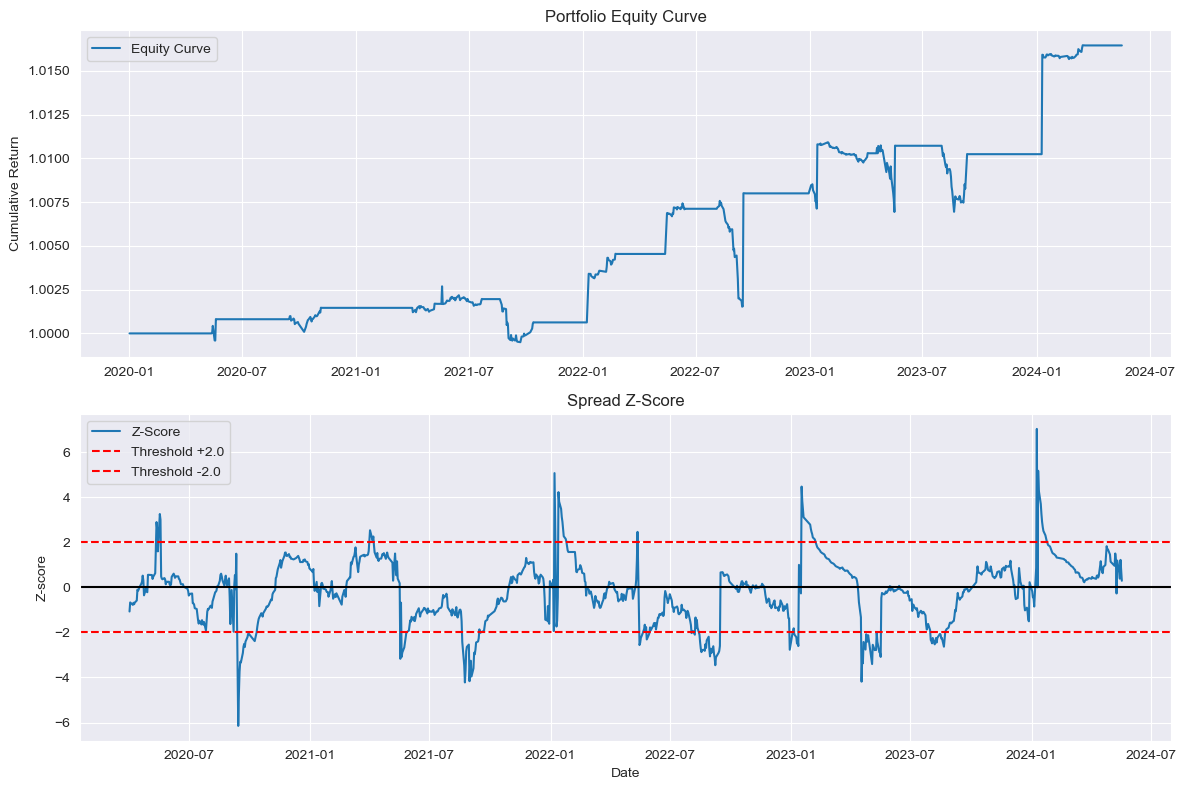

In [27]:
def calculate_performance_metrics(perf_df: pd.DataFrame):
    total_return = perf_df['equity_curve'].iloc[-1] - 1
    sharpe_ratio = perf_df['returns'].mean() / perf_df['returns'].std() * np.sqrt(252) if perf_df['returns'].std() > 0 else np.nan
    cum_returns = perf_df['equity_curve']
    running_max = np.maximum.accumulate(cum_returns)
    drawdown = (cum_returns - running_max) / running_max
    max_drawdown = drawdown.min()
    print(f'Total Return: {total_return:.2%}')
    print(f'Sharpe Ratio: {sharpe_ratio:.2f}')
    print(f'Maximum Drawdown: {max_drawdown:.2%}')

calculate_performance_metrics(equity_df)

# 绘图
fig, ax = plt.subplots(2, 1, figsize=(12, 8))
ax[0].plot(equity_df.index, equity_df['equity_curve'], label='Equity Curve')
ax[0].set_title('Portfolio Equity Curve')
ax[0].set_ylabel('Cumulative Return')
ax[0].grid(True)
ax[0].legend()

spread_series = bt.strategy.spread_history
rolling_mean = spread_series.rolling(window=lookback_window).mean()
rolling_std = spread_series.rolling(window=lookback_window).std()
z_score = (spread_series - rolling_mean) / rolling_std

ax[1].plot(z_score.index, z_score.values, label='Z-Score')
ax[1].axhline(z_threshold, color='r', linestyle='--', label=f'Threshold +{z_threshold}')
ax[1].axhline(-z_threshold, color='r', linestyle='--', label=f'Threshold -{z_threshold}')
ax[1].axhline(0.0, color='k', linestyle='-')
ax[1].set_title('Spread Z-Score')
ax[1].set_ylabel('Z-score')
ax[1].set_xlabel('Date')
ax[1].grid(True)
ax[1].legend()

plt.tight_layout()
plt.show()
